# Question 3 .Visualize the data using PCA. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Retina mode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
import os
sys.path.insert(0, os.path.abspath('..'))
# By inserting os.path.abspath('..') at the beginning of sys.path, you are adding the parent directory of your current working directory to the module search path.
# This allows Python to locate modules in the parent directory, which might not be included in the default sys.path.
from latexify import latexify, format_axes

In [2]:
# Loading linear_acc_train data
linear_acc_train = np.load('../FinalDataset/linear_acc_train.npy')
linear_acc_test = np.load('../FinalDataset/linear_acc_test.npy')

# Loading the X_train and X_test data
X_train = np.load('../FinalDataset/X_train.npy')
X_test = np.load('../FinalDataset/X_test.npy')

# Loading the y_train and y_test data
y_train = np.load('../FinalDataset/y_train.npy')
y_test = np.load('../FinalDataset/y_test.npy')

### 3.1 Use PCA (Principal Component Analysis) on Total Acceleration 
 to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities.

Shape of the data after PCA: (126, 2)


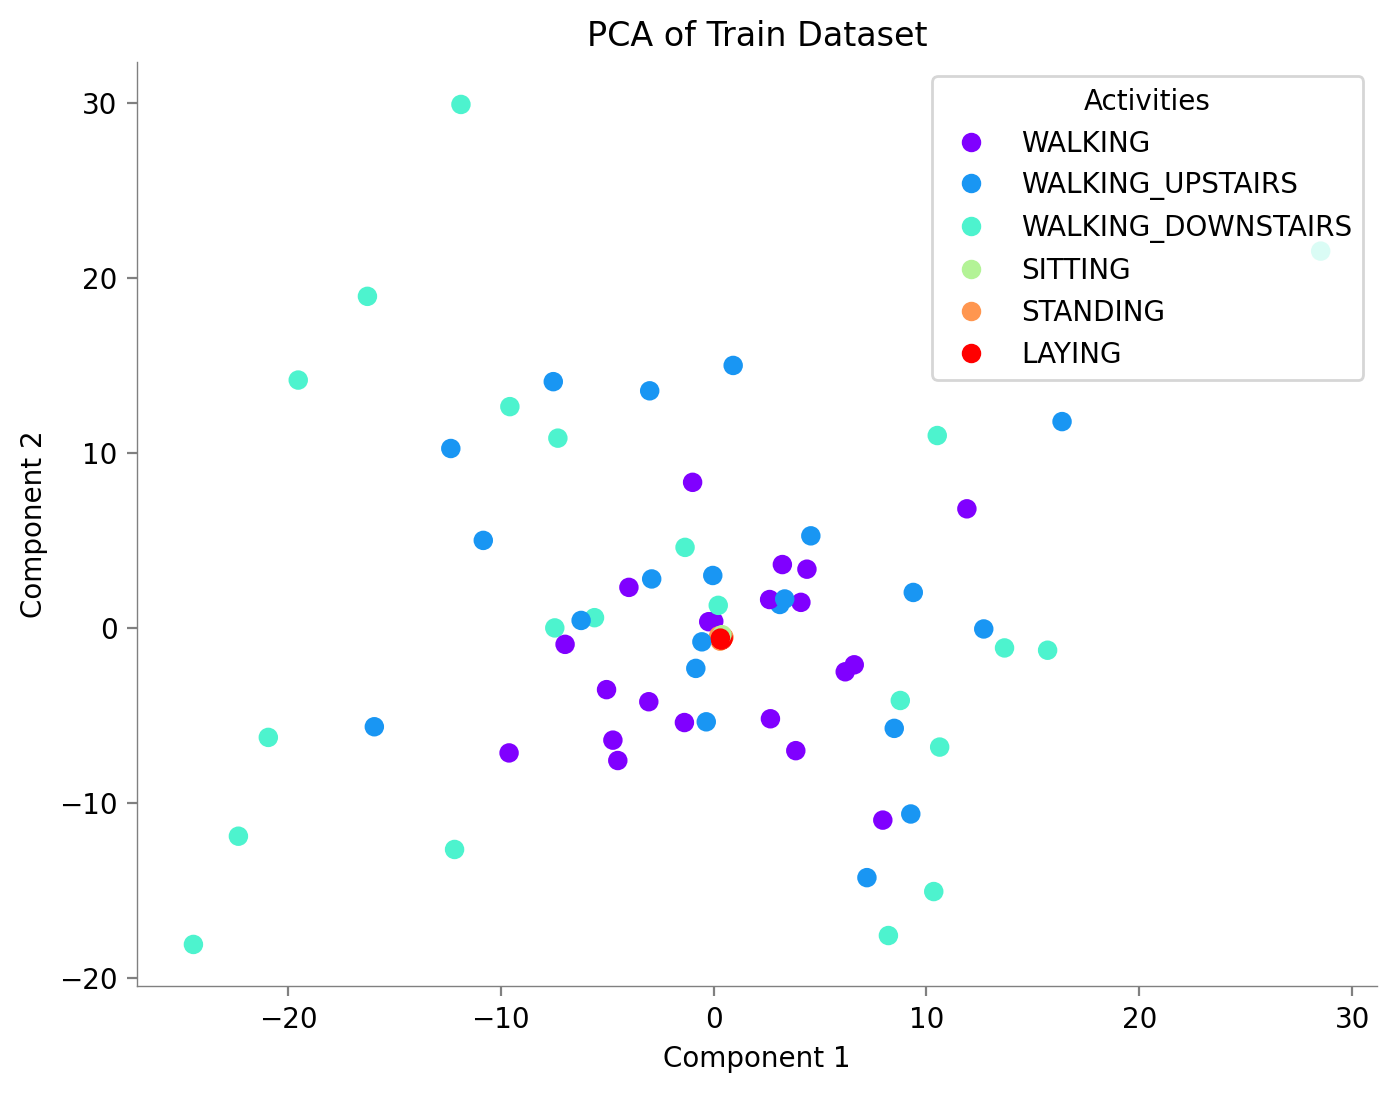

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# standardizing the data before applying PCA
scaler = StandardScaler()
linear_acc_train_standardized = scaler.fit_transform(linear_acc_train)

# print(linear_acc_train_standardized)

# applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(linear_acc_train_standardized)

# print(X_pca)

print("Shape of the data after PCA:", X_pca.shape)

# Plotting the PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='rainbow')

classes = {1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS", 4: "SITTING", 5: "STANDING", 6: "LAYING"}
unique_labels = np.unique(y_train)
legend_labels = [classes[i] for i in unique_labels]
legend_elements = scatter.legend_elements()[0]
legend = plt.legend(legend_elements, legend_labels, title='Activities')

format_axes(plt.gca())
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('PCA of Train Dataset')
plt.show()


### 3.2 Picking features using TSFEL
The features picked are: absolute energy, mean absolute deviation, peak to peak distance, rms, autocorrelation, variance, mean and slope

In [4]:
import tsfel
# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_tsfel = tsfel.time_series_features_extractor(cfg,X_train, verbose=1,fs =50)
X_test_tsfel = tsfel.time_series_features_extractor(cfg,X_test, verbose=1,fs =50)
'''
verbose parameter controls the amount of information that is printed out during the execution of the function.
verbose=0: Suppresses all output. No messages will be printed.
verbose=1: Prints basic information, often minimal progress updates.
verbose=2 and above: Prints more detailed information, including potentially extensive logs or debug information.

fs : sampling frequency
'''

'''
When you call tsfel.get_features_by_domain(), it returns a configuration (cfg) that specifies which features to extract from your time series data.
The cfg variable holds the configuration that tells TSFEL which features to compute. This configuration can be customized or retrieved for specific domains.
When you call tsfel.get_features_by_domain(), it retrieves a default configuration that includes a wide variety of features from all domains (time, frequency, and statistical).

Time-domain features: Mean, standard deviation, kurtosis, skewness, etc.
Frequency-domain features: Spectral entropy, power spectral density, etc.
Statistical features: Quantiles, autocorrelation, etc

'''
print("Shape of train data after performing feature creation using tsfel:",X_train_tsfel.shape)
print("Shape of test data after performing feature creation using tsfel:",X_test_tsfel.shape)
# print(X_train_tsfel_features.columns)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Shape of train data after performing feature creation using tsfel: (126, 1152)
Shape of test data after performing feature creation using tsfel: (54, 1152)


In [19]:
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train_tsfel)
print(corr_features[:5])
X_train_tsfel_updated = X_train_tsfel.drop(corr_features, axis=1)
X_test_tsfel_updated = X_test_tsfel.drop(corr_features, axis=1)
# X_test_tsfel.drop(corr_features, axis=1, inplace=True)
print(X_train_tsfel_updated.shape , X_test_tsfel_updated.shape)

# Remove low variance features
selector = VarianceThreshold(threshold = 0) # default is 0
X_train_tsfel_modified = selector.fit_transform(X_train_tsfel_updated)
X_test_tsfel_modified = selector.transform(X_test_tsfel_updated)
print(X_train_tsfel_modified.shape , X_test_tsfel_modified.shape)

np.save('../FinalDataset/X_train_tsfel_reduced.npy', X_train_tsfel_modified)
np.save('../FinalDataset/X_test_tsfel_reduced.npy', X_test_tsfel_modified)



['0_Area under the curve', '0_Average power', '0_ECDF Percentile_1', '0_FFT mean coefficient_211', '0_FFT mean coefficient_212']
(126, 844) (54, 844)
(126, 803) (54, 803)


In [29]:
# Normalising Features
scaler = preprocessing.StandardScaler()
nX = scaler.fit_transform(X_train_tsfel_modified)
nX_ = scaler.transform(X_test_tsfel_modified)
print(X_train_tsfel.shape , X_test_tsfel.shape)

pca = PCA(n_components=62)
X = pca.fit_transform(nX)
X_ = pca.transform(nX_)

print("Shape of train data after PCA:", X.shape)
print("Shape of test data after PCA:", X_.shape)

np.save('../FinalDataset/X_train_tsfel_62.npy', X)
np.save('../FinalDataset/X_test_tsfel_62.npy', X_)

(126, 1152) (54, 1152)
Shape of train data after PCA: (126, 62)
Shape of test data after PCA: (54, 62)


In [6]:
# # Initialize SelectKBest to select the top K features based on ANOVA F-value
# selector_kbest = SelectKBest(score_func=f_classif, k=20)  # You can adjust 'k' as needed

# # Fit SelectKBest on the training data and transform both training and test data
# X_train_kbest = selector_kbest.fit_transform(nX_train, y_train)  # y_train should be your labels for training data
# X_test_kbest = selector_kbest.transform(nX_test)

# print("Shape of train data after SelectKBest:", X_train_kbest.shape)
# print("Shape of test data after SelectKBest:", X_test_kbest.shape)

In [28]:
# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train_tsfel = scaler.fit_transform(X_train_tsfel_modified)
nX_test_tsfel = scaler.transform(X_test_tsfel_modified)
print(X_train_tsfel.shape , X_test_tsfel.shape)

pca = PCA(n_components=2)
X_train_tsfel_pca = pca.fit_transform(nX_train_tsfel)
X_test_tsfel_pca = pca.transform(nX_test_tsfel)

print("Shape of train data after PCA:", X_train_tsfel_pca.shape)
print("Shape of test data after PCA:", X_test_tsfel_pca.shape)

np.save('../FinalDataset/X_train_tsfel_pca.npy', X_train_tsfel_pca)
np.save('../FinalDataset/X_test_tsfel_pca.npy', X_test_tsfel_pca)

(126, 1152) (54, 1152)
Shape of train data after PCA: (126, 2)
Shape of test data after PCA: (54, 2)


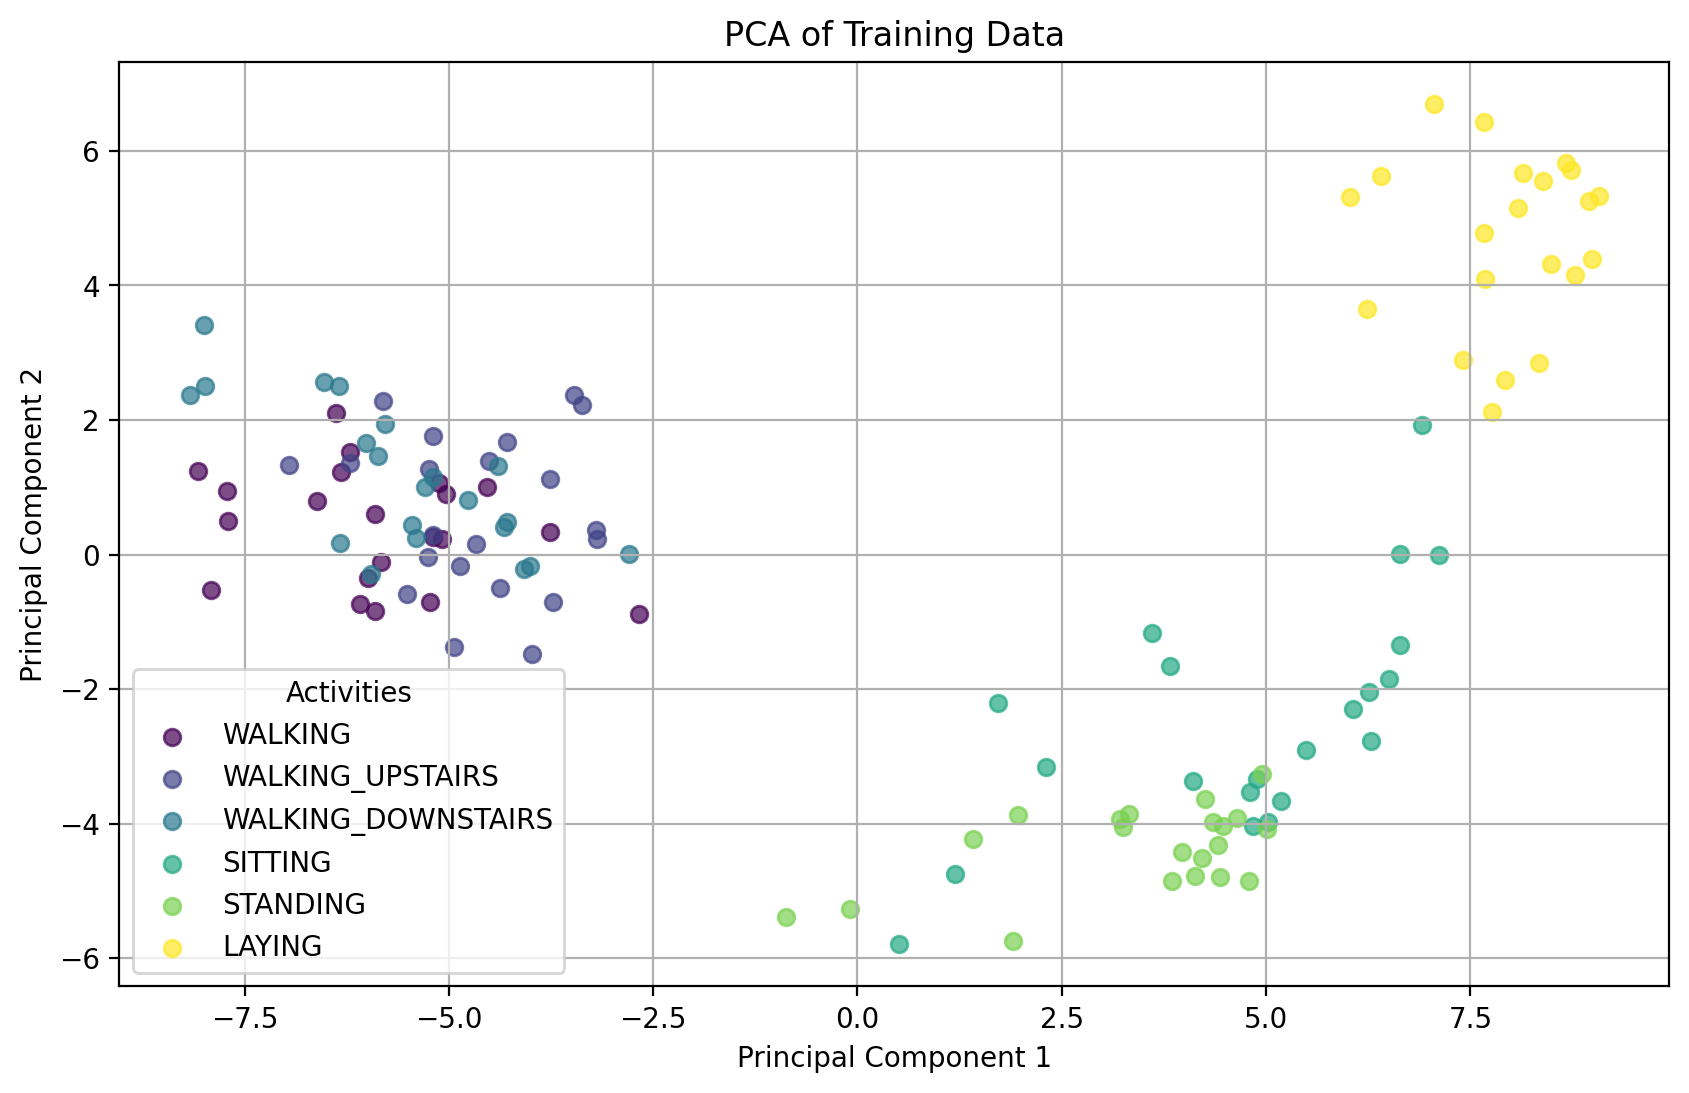

In [8]:
# Create a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10, 6))

# Plot each class
for i, label in enumerate(unique_labels):
    mask = y_train == label
    plt.scatter(X_train_tsfel_pca[mask, 0], X_train_tsfel_pca[mask, 1], 
                color=colors[i], label=classes[label], alpha=0.7)

plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend
plt.legend(title='Activities')
plt.grid(True)
plt.show()

 ### Loadings

In [9]:
# # Find the indices of the features with the maximum absolute loadings for each principal component
# top_features_PC1 = loadings_df['PC1'].abs().nlargest(10)
# top_features_PC2 = loadings_df['PC2'].abs().nlargest(10)

# # Combine them into a single DataFrame
# top_features = pd.concat([top_features_PC1, top_features_PC2]).drop_duplicates().sort_values(ascending=False)

# # Display the top features with their loadings
# print(top_features)
# # Find the indices of the features with the maximum absolute loadings for each principal component
# top_features_PC1 = loadings_df['PC1'].abs().nlargest(10)
# top_features_PC2 = loadings_df['PC2'].abs().nlargest(10)

# # Combine them into a single DataFrame
# top_features = pd.concat([top_features_PC1, top_features_PC2]).drop_duplicates().sort_values(ascending=False)

# # Display the top features with their loadings
# print(top_features)
# # Plot the top features by their loadings on PC1 and PC2
# top_features_df = loadings_df.loc[top_features.index]

# top_features_df.plot(kind='bar', figsize=(12, 6))
# plt.title('Top Features with Maximum Loadings on PC1 and PC2')
# plt.xlabel('Features')
# plt.ylabel('Loadings')
# plt.show()



### Direct pca on tsfel 

(126, 1152) (54, 1152)


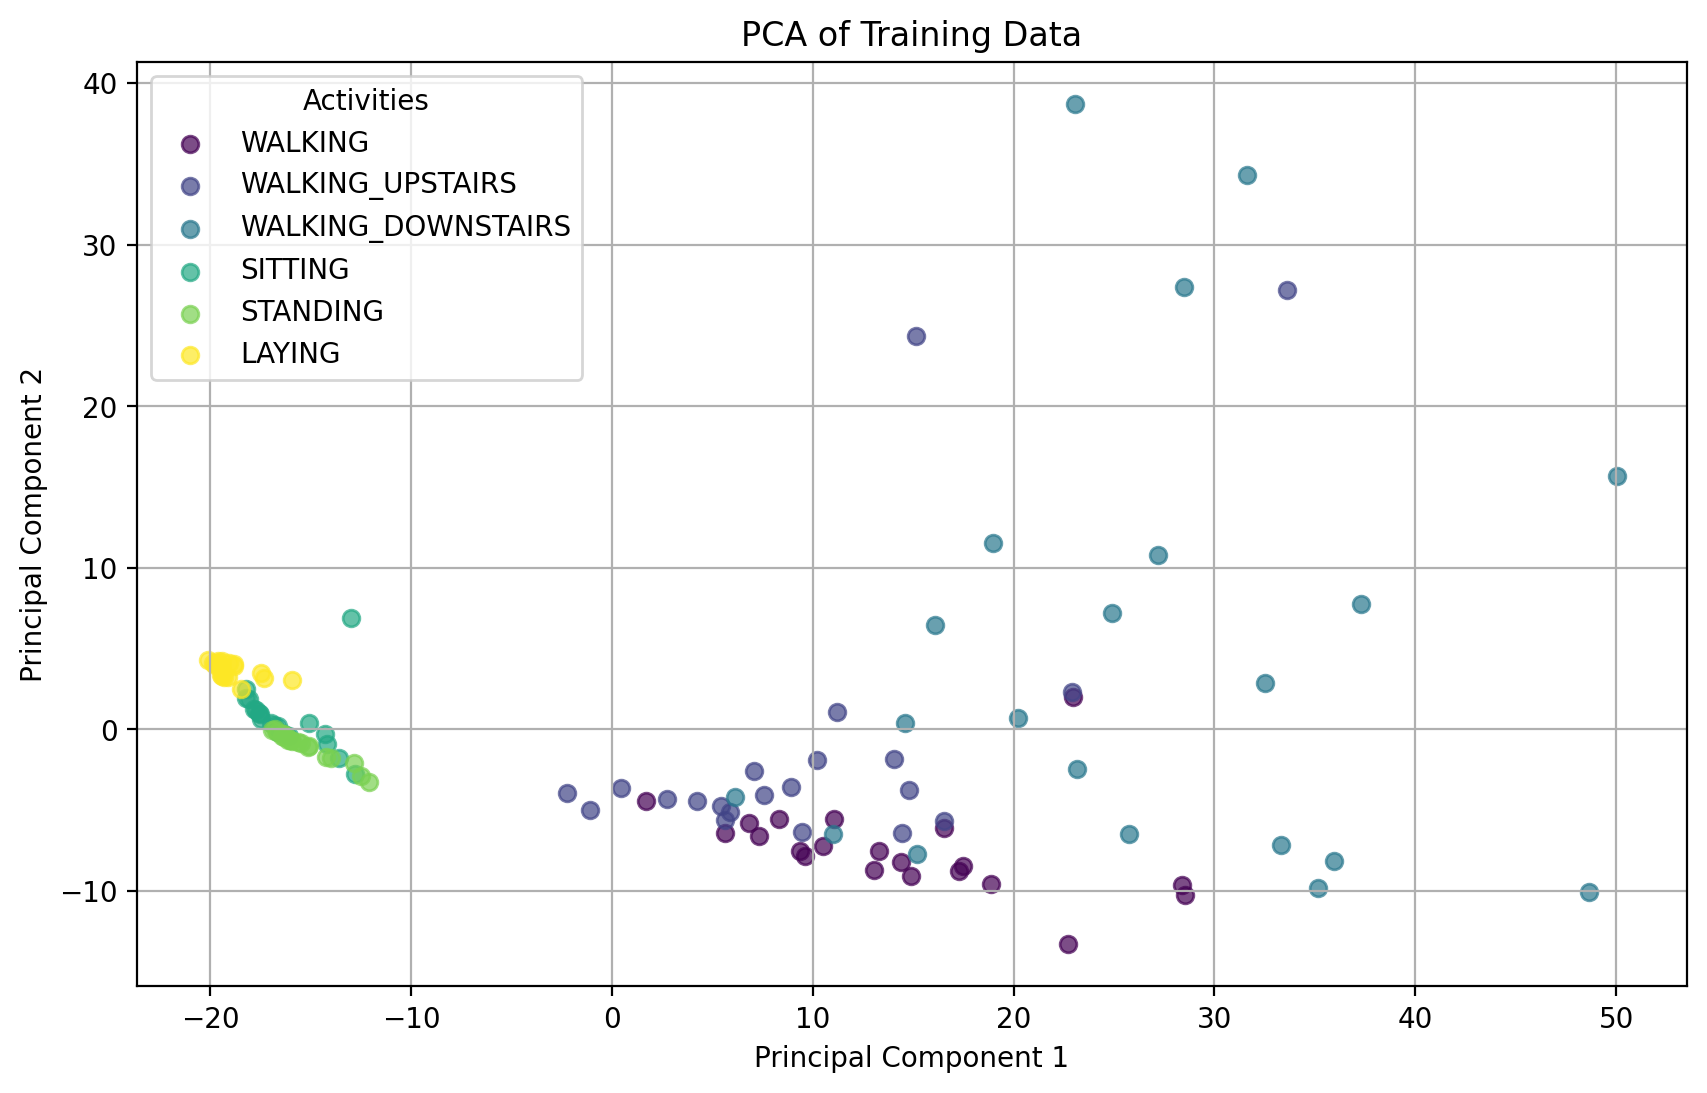

In [10]:
# Normalising Features



from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

# # Highly correlated features are removed
# corr_features = tsfel.correlated_features(X_train_tsfel)
# X_train_tsfel_updated = X_train_tsfel.drop(corr_features, axis=1)
# X_test_tsfel_updated = X_test_tsfel.drop(corr_features, axis=1)
# # X_test_tsfel.drop(corr_features, axis=1, inplace=True)
# print(X_train_tsfel_updated.shape , X_test_tsfel_updated.shape)

# # Remove low variance features
# selector = VarianceThreshold(threshold = 0.1) # default is 0
# X_train_tsfel_modified = selector.fit_transform(X_train_tsfel_updated)
# X_test_tsfel_modified = selector.transform(X_test_tsfel_updated)
# print(X_train_tsfel_modified.shape , X_test_tsfel.shape)


scaler = preprocessing.StandardScaler()
nX_train_tsfel = scaler.fit_transform(X_train_tsfel)
nX_test_tsfel = scaler.transform(X_test_tsfel)
print(X_train_tsfel.shape , X_test_tsfel.shape)

pca = PCA(n_components=2)
X_train_tsfel_pca_direct = pca.fit_transform(nX_train_tsfel)
X_test_tsfel_pca_direct = pca.transform(nX_test_tsfel)

# Create a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10, 6))

# Plot each class
for i, label in enumerate(unique_labels):
    mask = y_train == label
    plt.scatter(X_train_tsfel_pca_direct[mask, 0], X_train_tsfel_pca_direct[mask, 1], 
                color=colors[i], label=classes[label], alpha=0.7)

plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend
plt.legend(title='Activities')
plt.grid(True)
plt.show()


#### Testing how mnay compinents should be there to provide maximum informatino

(126, 1152) (54, 1152)
(126, 1152) (54, 1152)


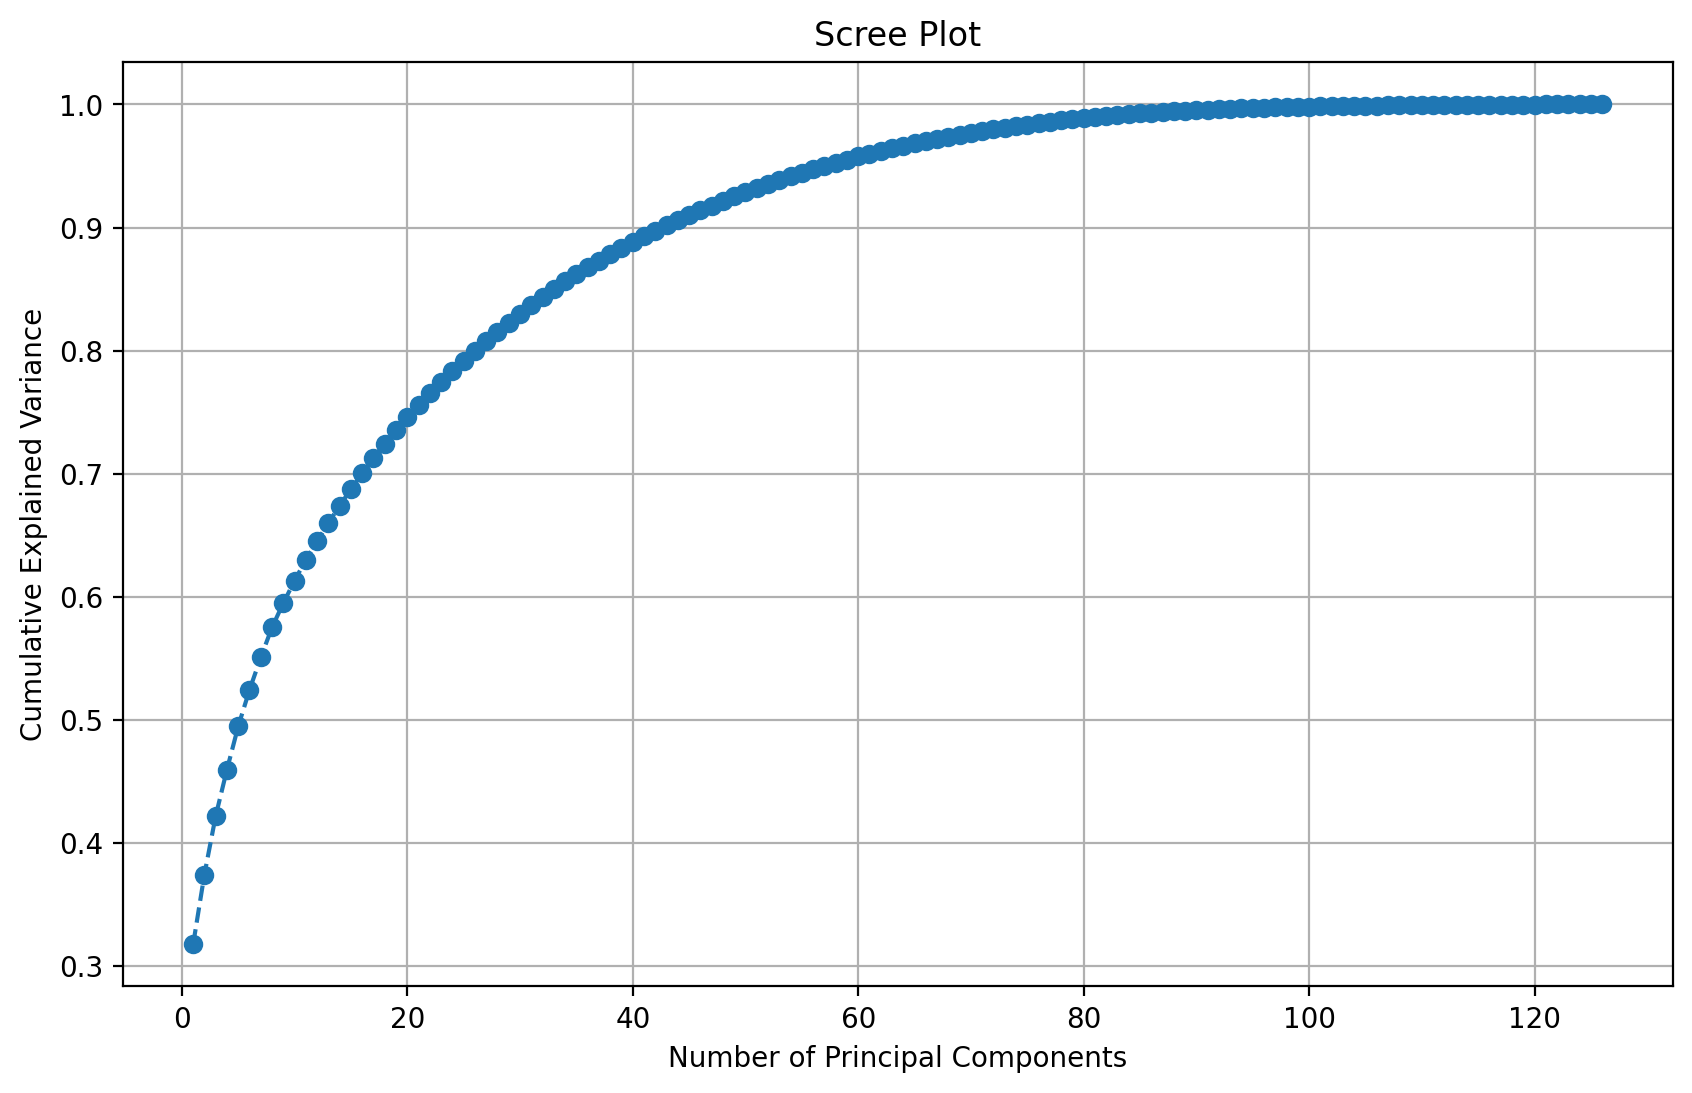

Number of components to retain 95% variance: 57
Reduced training data shape:  (126, 57)
Reduced testing data shape:  (54, 57)
Variance captured by 2 components: 0.37
Variance captured by 3 components: 0.42


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(X_train_tsfel.shape , X_test_tsfel.shape)
# Normalising Features
scaler = preprocessing.StandardScaler()
X_train_tsfel_test = scaler.fit_transform(X_train_tsfel)
X_test_tsfel_test = scaler.transform(X_test_tsfel)
print(X_train_tsfel_test.shape , X_test_tsfel_test.shape)
# Perform PCA
pca = PCA()
pca.fit(X_train_tsfel_test)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Decide on the number of components to retain
variance_threshold = 0.95  # For example, you want to retain 95% of the variance
num_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1

print(f"Number of components to retain {variance_threshold * 100:.0f}% variance: {num_components}")

# Apply PCA with the selected number of components
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_tsfel_test)
X_test_pca = pca.transform(X_test_tsfel_test)

print("Reduced training data shape: ", X_train_pca.shape)
print("Reduced testing data shape: ", X_test_pca.shape)

# Print the variance captured by the first 2 and 3 components
variance_2_components = cumulative_explained_variance[1]  # 2 components
variance_3_components = cumulative_explained_variance[2]  # 3 components

print(f"Variance captured by 2 components: {variance_2_components:.2f}")
print(f"Variance captured by 3 components: {variance_3_components:.2f}")

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
(54, 116) (54, 116)


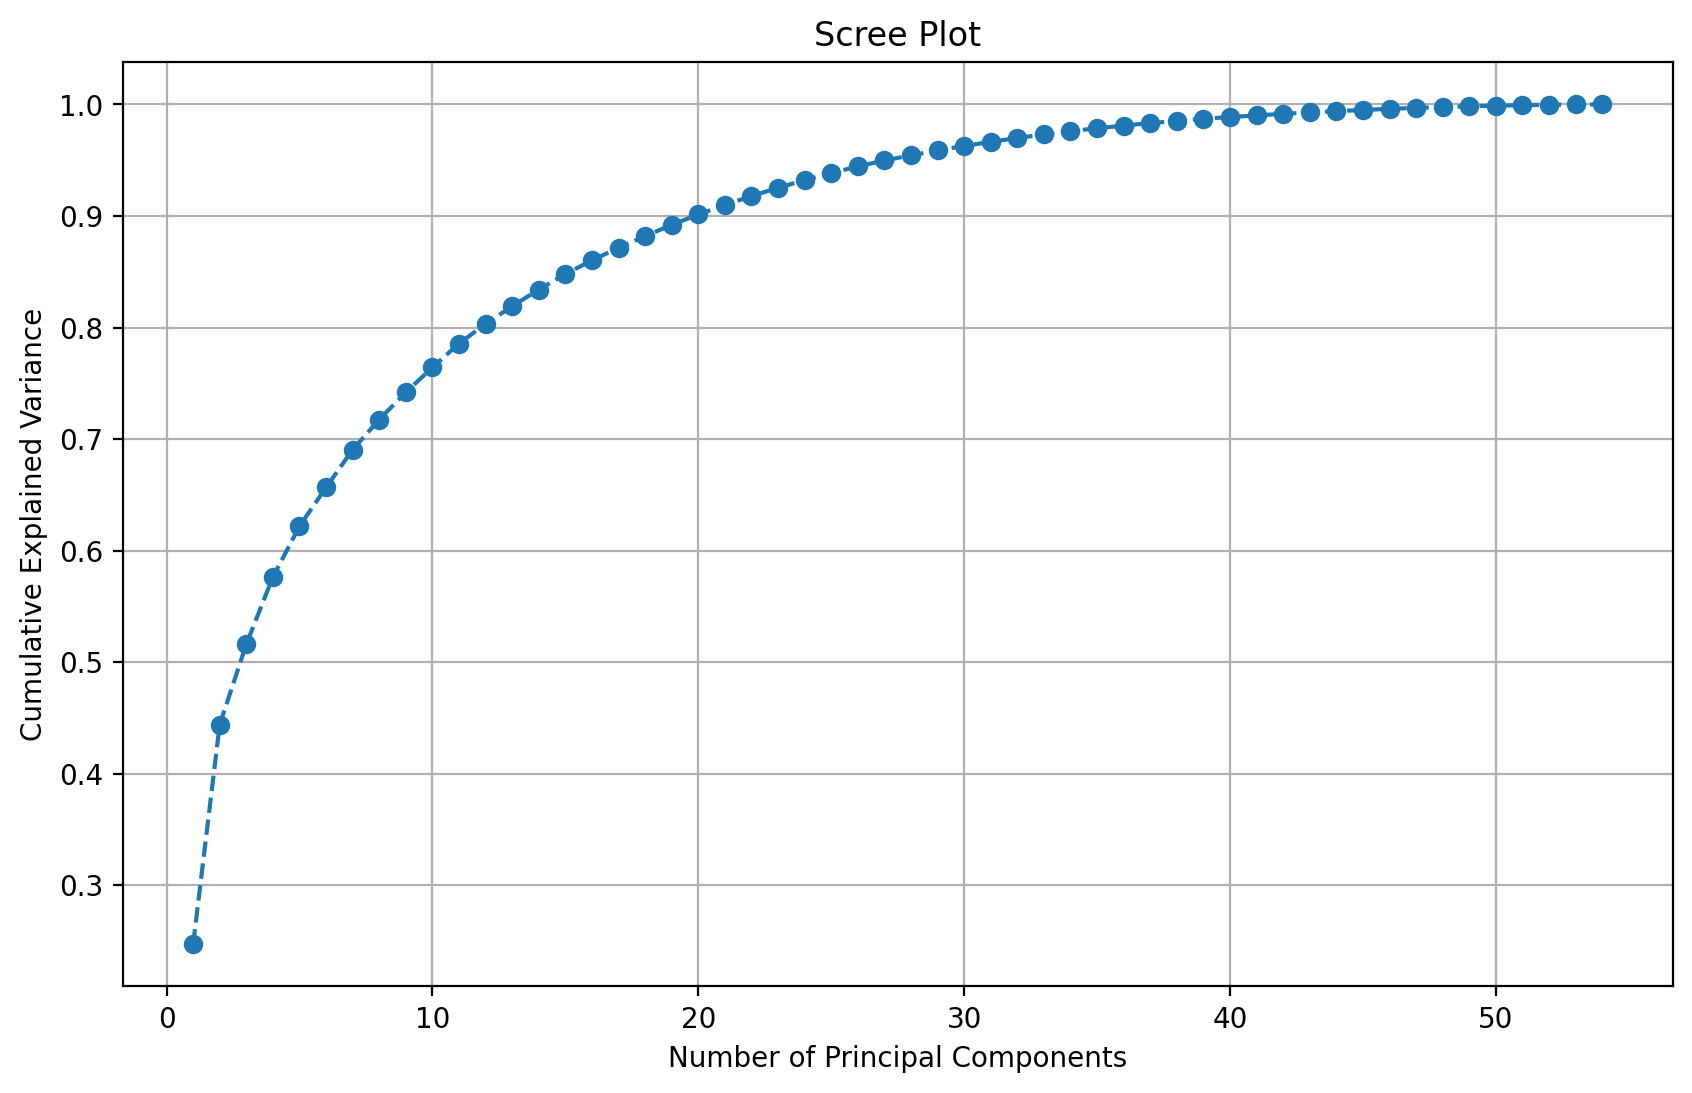

Number of components to retain 95% variance: 28
Reduced training data shape:  (126, 28)
Reduced testing data shape:  (54, 28)
Variance captured by 2 components: 0.44
Variance captured by 3 components: 0.52


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tsfel
# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_tsfel = tsfel.time_series_features_extractor(cfg,X_train, verbose=1,fs =50)
X_test_tsfel = tsfel.time_series_features_extractor(cfg,X_test, verbose=1,fs =50)

# Normalising Features
scaler = preprocessing.StandardScaler()
X_train_tsfel_test = scaler.fit_transform(X_train_tsfel_modified)
X_test_tsfel_test = scaler.transform(X_test_tsfel_modified)
print(X_test_tsfel_test.shape , X_test_tsfel_test.shape)
# Perform PCA
pca = PCA()
pca.fit(X_test_tsfel_test)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Decide on the number of components to retain
variance_threshold = 0.95  # For example, you want to retain 95% of the variance
num_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1

print(f"Number of components to retain {variance_threshold * 100:.0f}% variance: {num_components}")

# Apply PCA with the selected number of components
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_tsfel_test)
X_test_pca = pca.transform(X_test_tsfel_test)

print("Reduced training data shape: ", X_train_pca.shape)
print("Reduced testing data shape: ", X_test_pca.shape)

# Print the variance captured by the first 2 and 3 components
variance_2_components = cumulative_explained_variance[1]  # 2 components
variance_3_components = cumulative_explained_variance[2]  # 3 components

print(f"Variance captured by 2 components: {variance_2_components:.2f}")
print(f"Variance captured by 3 components: {variance_3_components:.2f}")

#### Possibilities

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


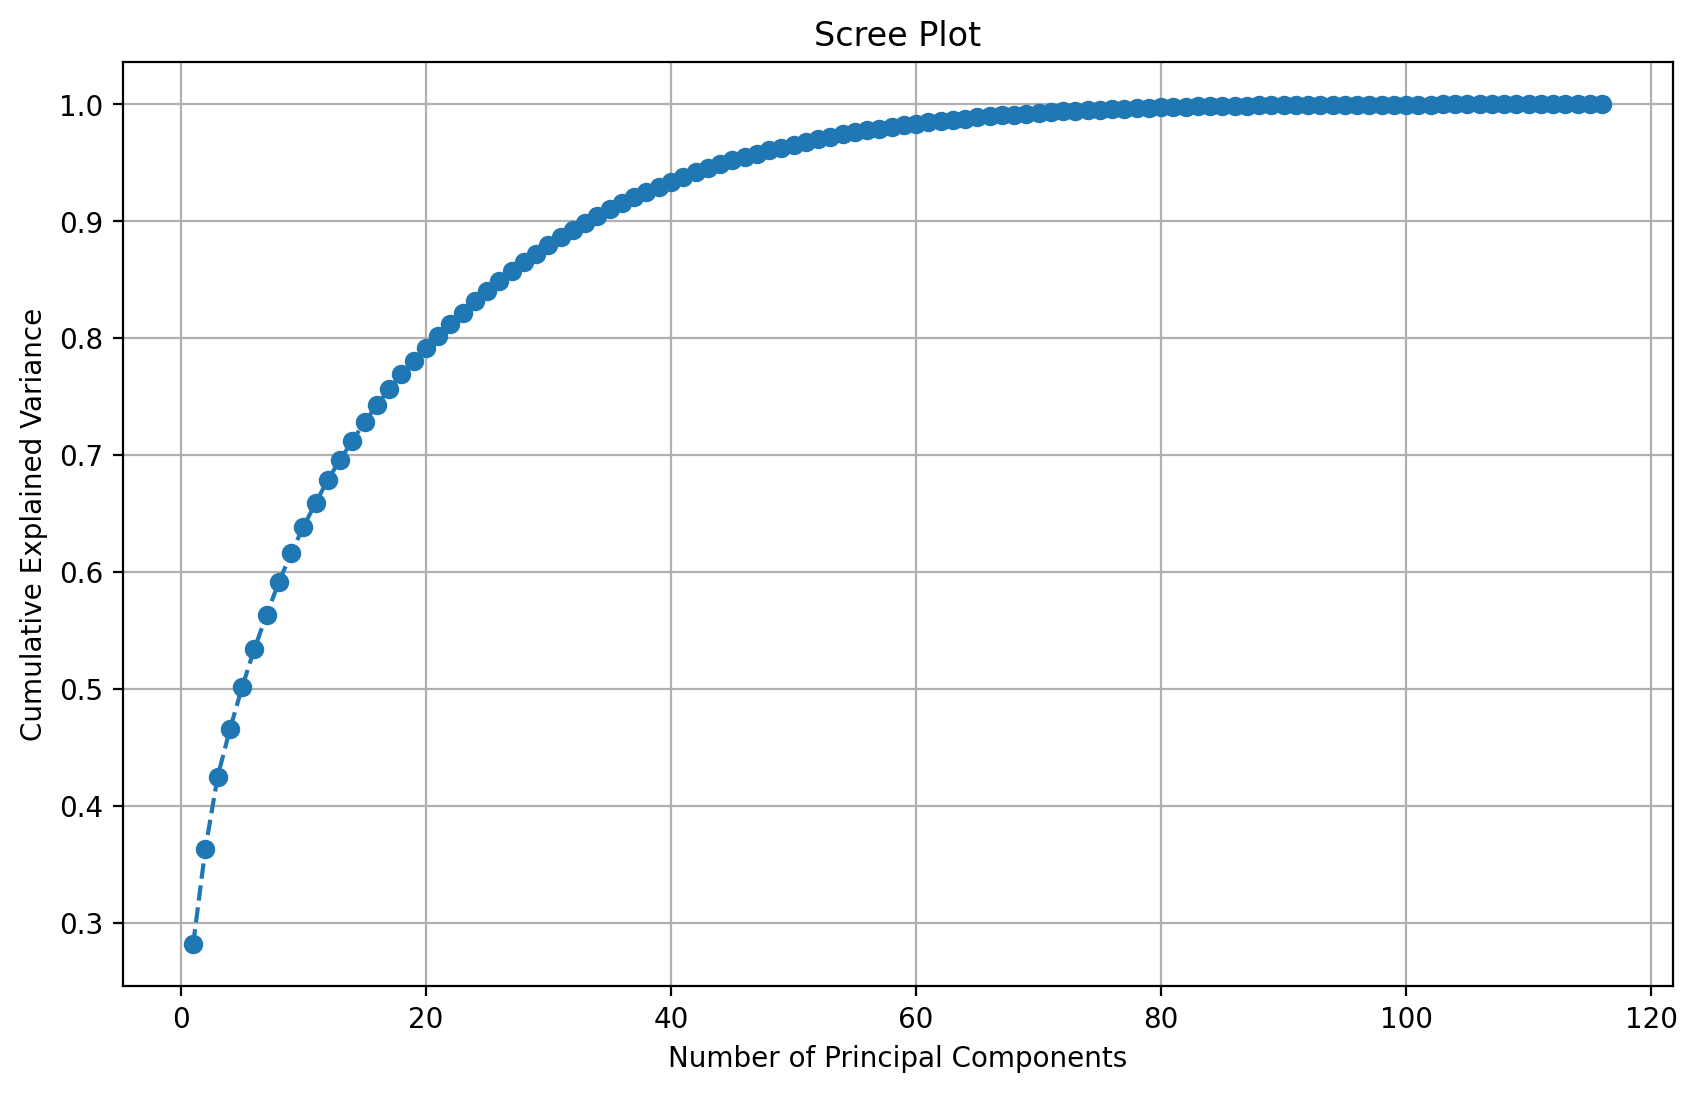

Reduced training data shape:  (126, 45)
Reduced testing data shape:  (54, 45)
Variance captured by 2 components: 0.36
Variance captured by 3 components: 0.42


In [13]:
import tsfel
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_tsfel = tsfel.time_series_features_extractor(cfg, X_train, verbose=1, fs=50)
X_test_tsfel = tsfel.time_series_features_extractor(cfg, X_test, verbose=1, fs=50)

# Remove highly correlated features
corr_features = tsfel.correlated_features(X_train_tsfel)
X_train_tsfel_updated = X_train_tsfel.drop(corr_features, axis=1)
X_test_tsfel_updated = X_test_tsfel.drop(corr_features, axis=1)

# Remove low variance features
selector = VarianceThreshold(threshold=0.1)
X_train_tsfel_modified = selector.fit_transform(X_train_tsfel_updated)
X_test_tsfel_modified = selector.transform(X_test_tsfel_updated)

# Normalize features
scaler = preprocessing.StandardScaler()
X_train_tsfel_test = scaler.fit_transform(X_train_tsfel_modified)
X_test_tsfel_test = scaler.transform(X_test_tsfel_modified)

# Perform PCA
pca = PCA()
pca.fit(X_train_tsfel_test)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Decide on the number of components to retain
variance_threshold = 0.95  # Retain 95% of the variance
num_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1

# Apply PCA with the selected number of components
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_tsfel_test)
X_test_pca = pca.transform(X_test_tsfel_test)

print("Reduced training data shape: ", X_train_pca.shape)
print("Reduced testing data shape: ", X_test_pca.shape)

# Print the variance captured by the first 2 and 3 components
variance_2_components = cumulative_explained_variance[1] if len(cumulative_explained_variance) > 1 else None
variance_3_components = cumulative_explained_variance[2] if len(cumulative_explained_variance) > 2 else None

print(f"Variance captured by 2 components: {variance_2_components:.2f}" if variance_2_components is not None else "Not enough components for 2")
print(f"Variance captured by 3 components: {variance_3_components:.2f}" if variance_3_components is not None else "Not enough components for 3")

# # Save the reduced dataset
# np.save('../FinalDataset/X_train_tsfel_reduced.npy', X_train_pca)
# np.save('../FinalDataset/X_test_tsfel_reduced.npy', X_test_pca)
